In [12]:
# Load common libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
df = pd.read_csv('heart.csv')

# Display basic info
print(df.info())  # Check column types and missing values
print(df.head())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160

In [17]:
# For ML purposes, all strings are converted to int
df['Sex'] = df['Sex'].replace({'M': 0, 'F': 1})
df['ChestPainType'] = df['ChestPainType'].replace({'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3})
df['RestingECG'] = df['RestingECG'].replace({'Normal': 0, 'ST': 1, 'LVH': 2})
df['ExerciseAngina'] = df['ExerciseAngina'].replace({'N': 0, 'Y': 1})
df['ST_Slope'] = df['ST_Slope'].replace({'Up': 0, 'Down': 1, 'Flat': 2})

# IGNORE WARNING

/var/folders/ts/33rvr9mx0yb7mq12ds2w0r9m0000gn/T/ipykernel_78356/204343278.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ST_Slope'] = df['ST_Slope'].replace({'Up': 0, 'Down': 1, 'Flat': 2})


In [18]:
# Separate features (X) and target variable (y)
X = df.drop(columns=['HeartDisease'])  # Features
y = df['HeartDisease']  # Target variable

In [19]:
# Library needed
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Library needed
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Library needed
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [23]:
# Library needed
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.8750

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        82
           1       0.88      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



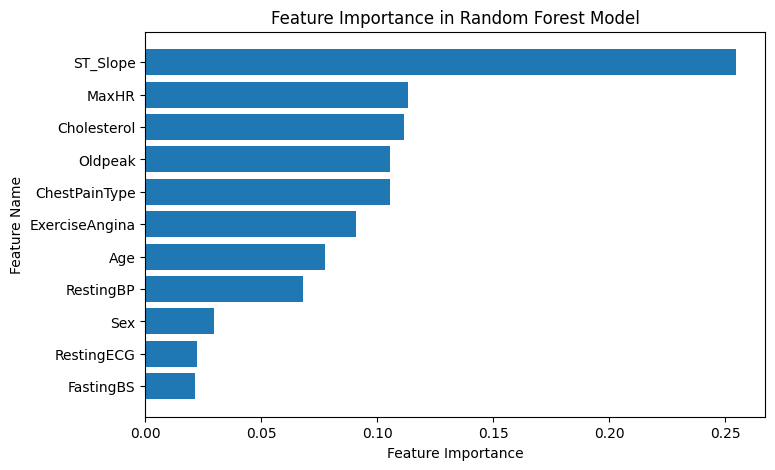

In [24]:
# Get feature importance from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples required in a leaf node
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train the optimized model
best_model = grid_search.best_estimator_

# Evaluate the optimized model
y_pred_optimized = best_model.predict(X_test_scaled)
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)

print("\nOptimized Model Accuracy:", optimized_accuracy)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Optimized Model Accuracy: 0.8804347826086957


In [26]:
import joblib

# Save optimized model
joblib.dump(best_model, 'optimized_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\nOptimized Model Saved Successfully!")


Optimized Model Saved Successfully!
